In [155]:
import numpy as np

from keyrover import *

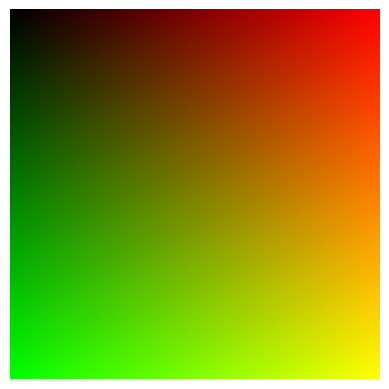

In [197]:
x = np.linspace(0, 255, 200)
y = np.linspace(0, 255, 200)
xx, yy = np.meshgrid(x, y)
ones = np.ones(xx.shape)
coordinates = np.stack((xx, yy, ones), axis=-1)

p1 = np.array([50, 50])
p2 = np.array([128, 0])
p3 = np.array([200, 200])
p4 = np.array([0, 255])

imshow(coordinates)

In [194]:
x1, y1 = p1
x2, y2 = p2
x3, y3 = p3
x4, y4 = p4

M = np.array([[x1, x2, x3],
              [y1, y2, y3],
              [1, 1, 1]])

H = np.linalg.inv(M) @ np.array([x4, y4, 1])
A = M * H

Ms = np.array([[0, 255, 255],
               [0, 0, 255],
               [1, 1, 1]])

Hs = np.linalg.inv(Ms) @ np.array([0, 255, 1])
B = Ms * Hs

C = B @ np.linalg.inv(A)
C

array([[     1.9451,     0.47443,     -120.98],
       [    0.94514,      1.4744,     -120.98],
       [  0.0030784,   0.0034983,     0.10792]])

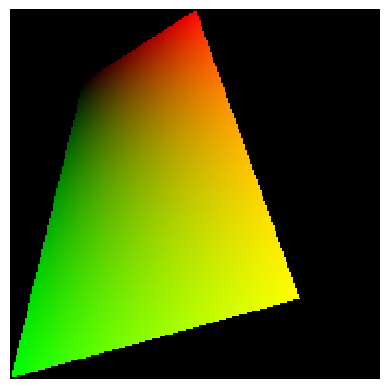

In [196]:
result = np.einsum('ij, xyj -> xyi', C, coordinates)
result = result / result[:, :, -1][:, :, None]  # dehomogenization
result[result.max(axis=2) > 255] = 0
result[result.min(axis=2) < 0] = 0
imshow(result)